<a href="https://colab.research.google.com/github/arthurziegler/transformers-for-NLP/blob/main/notebooks/Sentiment_Analysis_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## New notebook for the tansformers course
!pip install transformers

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2022-07-30 20:22:53--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  5.00MB/s    in 0.7s    

2022-07-30 20:22:54 (5.00 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [3]:
from transformers import pipeline

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as pyplot

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
# Basic pipeline
classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [5]:
type(classifier)

transformers.pipelines.text_classification.TextClassificationPipeline

In [6]:
# Basic dictionary output
classifier("This is such a great movie!")

[{'label': 'POSITIVE', 'score': 0.9998759031295776}]

In [7]:
classifier("This show was not interesting.")

[{'label': 'NEGATIVE', 'score': 0.9997904896736145}]

In [8]:
classifier("This show was interesting.")

[{'label': 'POSITIVE', 'score': 0.9997681975364685}]

In [9]:
classifier("This show was not bad at all.")

[{'label': 'POSITIVE', 'score': 0.9989770650863647}]

In [10]:
classifier("I can't say that this was a good movie.")

[{'label': 'NEGATIVE', 'score': 0.9826212525367737}]

In [11]:
# Multiple inputs as a list
classifier([
    "This course is just what I needed.",
    "I can't understand any of this. Instructor kept telling me to meet the \
    prerequisites. What prerequisites? Why doe he keep saying that?"
])

[{'label': 'POSITIVE', 'score': 0.9991594552993774},
 {'label': 'NEGATIVE', 'score': 0.9975770115852356}]

In [12]:
# Let's setup the notebook to use the GPU for the processing.
import torch

In [13]:
torch.cuda.is_available()

True

In [14]:
# Gets the GPU 'name'
torch.cuda.current_device()

0

In [15]:
# Create the model using the GPU
classifier = pipeline("sentiment-analysis", device=0)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [16]:
df = pd.read_csv('AirlineTweets.csv')

In [17]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [19]:
df = df[['airline_sentiment', 'text']].copy()
df.head(2)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...


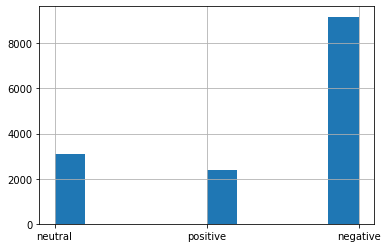

In [20]:
# Histograms help see if the data is inbalanced in any way
df['airline_sentiment'].hist()

In [22]:
# Classes are pretty unbalanced seeing as most tweets where classified as negative. We also have three classes in total but the hugging face model we'll use only supports binary classification.
df = df[df['airline_sentiment'] != 'neutral'].copy()
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)
df.head()

,airline_sentiment,text,target
1,positive,@VirginAmerica plus you've added commercials t...,1
3,negative,@VirginAmerica it's really aggressive to blast...,0
4,negative,@VirginAmerica and it's a really big bad thing...,0
5,negative,@VirginAmerica seriously would pay $30 a fligh...,0
6,positive,"@VirginAmerica yes, nearly every time I fly VX...",1


In [23]:
len(df)

11541

In [24]:
# Get a list of the dataset inputs
texts = df['text'].tolist()
predictions = classifier(texts)

In [36]:
len(predictions)

11541

In [27]:
predictions[0:10]

[{'label': 'POSITIVE', 'score': 0.6070843935012817},
 {'label': 'NEGATIVE', 'score': 0.9973449110984802},
 {'label': 'NEGATIVE', 'score': 0.9995823502540588},
 {'label': 'NEGATIVE', 'score': 0.9854250550270081},
 {'label': 'POSITIVE', 'score': 0.9553211331367493},
 {'label': 'POSITIVE', 'score': 0.9827088117599487},
 {'label': 'POSITIVE', 'score': 0.9994851350784302},
 {'label': 'POSITIVE', 'score': 0.9993509650230408},
 {'label': 'POSITIVE', 'score': 0.9940821528434753},
 {'label': 'POSITIVE', 'score': 0.9863133430480957}]

In [30]:
# We want to calculate the AUC(Area Under Curve) to validate the model but we can't have positive and negative results with the same score, so we will make negatives be closer to 0 and positives closer to 1
probs = []
for d in predictions:
    if d['label'].startswith('P'):
        probs.append(d['score'])
    else:
        probs.append(1 - d['score'])

In [32]:
probs[0:10]

[0.6070843935012817,
 0.0026550889015197754,
 0.0004176497459411621,
 0.014574944972991943,
 0.9553211331367493,
 0.9827088117599487,
 0.9994851350784302,
 0.9993509650230408,
 0.9940821528434753,
 0.9863133430480957]

In [33]:
# Now let's get a np.array of the predicted labels as integers
preds = []
for d in predictions:
    if d['label'] == 'POSITIVE':
        preds.append(1)
    else:
        preds.append(0)

preds = np.array(preds)
preds[0:20]

array([1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0])

In [49]:
# Next let's get the accuraccy of our predictions. This is the correct_prediction/all_predictions
correct_preds = df['target'] == preds
correct_preds = len(correct_preds[correct_preds == True])
all_preds = len(df['target'])
print("acc:", correct_preds/all_preds)

acc: 0.8898708950697514


In [50]:
# Let's make a confusion matrix to help us see the amount of TN and TP for our predictions as well.
cm = confusion_matrix(df['target'], preds, normalize = 'true')
cm

array([[0.90117673, 0.09882327],
       [0.15404147, 0.84595853]])

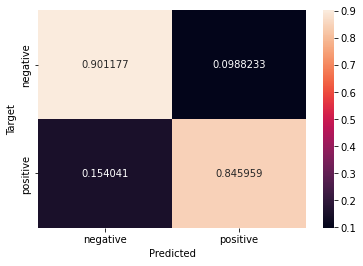

In [51]:
def plot_cm(cm):
    classes = ['negative', 'positive']
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")

plot_cm(cm)

In [52]:
# F1 Score
f1_score(df['target'], preds)

0.7587777566900741

In [53]:
# F1 Score inverting target and predictions to make negatives positives and vice-versa
f1_score(1 - df['target'], 1 - preds)

0.928647616908999

In [54]:
# AUC
roc_auc_score(df['target'], probs)

0.9485934229556097

In [57]:
# Does not change when values are inverted (just a demonstration as how it is different from the F1 score, which is not symmetrical)
roc_auc_score(1 - df['target'], 1 - np.array(probs))

0.9485934229556096